In [23]:
import pandas as pd
import os
from extensions.schemagen import schemagen
import numpy as np
from scipy import stats
import json
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
df = pd.read_csv(os.path.join("yellow_cab_data", "yellow_cab_data.csv"))
"""
One hot encodes a column in a dataframe.
@param pd.DataFrame df: the dataframe
@param str colname: the name of the column to be one-hot encoded
"""
def one_hot(df: pd.DataFrame, colname: str):
    hot = pd.get_dummies(df[colname], prefix=colname)
    df.drop(colname, axis=1, inplace=True)
    return df.join(hot)


"""
Preprocesses data by dropping columns we don't want and one-hot encoding
specified categorical ones.
@param pd.DataFrame data: the data to preprocess
@param list drop: column names to drop
@param list onehot: column names to onehot encode
"""
def preprocess_data(data: pd.DataFrame, drop=[], onehot=[]):
    df = data.copy()
    df = df.dropna(axis=0)
    # Drop features we don't want
    for feat in drop:
        df.drop(feat, axis=1, inplace=True)

    # One-hot encode categorical features
    for feat in onehot:
        df = one_hot(df, feat)

    # Encode store_and_fwd_flag
    store = (df["store_and_fwd_flag"] == "Y").astype(int)
    df["store_and_fwd_flag"] = store

    df = df[df["tip_amount"] > 0]

    for col in ['extra', 'mta_tax', 'improvement_surcharge', 'tolls_amount', 'congestion_surcharge', 'airport_fee']:
        df[col] = abs(df[col])

    df = df[(np.abs(stats.zscore(df.tip_amount))) < 3]

    return df

df = preprocess_data(df, 
                drop = ["tpep_pickup_datetime", "tpep_dropoff_datetime", 
                        "total_amount", "payment_type", "fare_amount", 
                        "trip_distance"]).reset_index(drop = True)

In [5]:
X, y = df.drop('tip_amount', axis = 1), df['tip_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

train_data = pd.concat([X_train, y_train], axis = 1)

train_data.to_csv(os.path.join("yellow_cab_data", "processed_train.csv"), index = False)

In [6]:
NUM_BINS = 20

In [7]:
schema_generator = schemagen.SchemaGenerator()
input_file = os.path.join("yellow_cab_data", "processed_train.csv")
schema_generator.read_and_parse_csv(input_csv_file = input_file,
                                    categorical_columns = ['PULocationID', 'DOLocationID'],
                                    num_bins = NUM_BINS)
parameters_json = schema_generator.get_parameters_json()

with open(os.path.join("yellow_cab_data", "parameters.json"), 'w') as fp:
    json.dump(parameters_json, fp, indent = 4)

In [35]:
!cd extensions/

!python extensions/transform.py --transform discretize --df yellow_cab_data/processed_train.csv --schema yellow_cab_data/parameters.json --output_dir df_transform_result/

print("Transform complete")

discretized = pd.read_csv(os.path.join("df_transform_result", "discretized.csv"))
discretized = discretized.replace({-1: 9})
discretized.to_csv(os.path.join("df_transform_result", "discretized.csv"), index = False)

!python extensions/check_domain.py --dataset df_transform_result/discretized.csv --domain df_transform_result/domain.json

print("Domain check complete")

!python extensions/adaptive_grid.py --epsilon 0.1 --dataset df_transform_result/discretized.csv --domain df_transform_result/domain.json --save yellow_cab_data/yellow_cab_data_synthetic.csv

print("Synthetic Data creation complete")

!python extensions/score.py --synthetic yellow_cab_data/yellow_cab_data_synthetic.csv --domain df_transform_result/domain.json --dataset df_transform_result/discretized.csv 

print("Scoring complete")

!python extensions/transform.py --transform undo_discretize --df yellow_cab_data/yellow_cab_data_synthetic.csv --schema yellow_cab_data/parameters.json --output_dir df_transform_result/

print("Synthetic reconstruction complete")

/home/shubham/private-pgm/src/mbi/__init__.py:15: UserWarning: MixtureInference disabled, please install jax and jaxlib
  warnings.warn('MixtureInference disabled, please install jax and jaxlib')
Transform complete
Dataset and domain file look good!
Domain check complete
/home/shubham/private-pgm/src/mbi/__init__.py:15: UserWarning: MixtureInference disabled, please install jax and jaxlib
  warnings.warn('MixtureInference disabled, please install jax and jaxlib')

Measuring ('extra',), L2 sensitivity 1.000000
Measuring ('DOLocationID',), L2 sensitivity 1.000000
Measuring ('passenger_count',), L2 sensitivity 1.000000
Measuring ('tolls_amount',), L2 sensitivity 1.000000
Measuring ('RatecodeID',), L2 sensitivity 1.000000
Measuring ('congestion_surcharge',), L2 sensitivity 1.000000
Measuring ('airport_fee',), L2 sensitivity 1.000000
Measuring ('mta_tax',), L2 sensitivity 1.000000
Measuring ('PULocationID',), L2 sensitivity 1.000000
Measuring ('VendorID',), L2 sensitivity 1.000000
Measuring

In [18]:
def reg_eval(model, X, y):
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    print("MAE: ", mae)
    # print("MSE: ", mse)
    return mae

original = pd.read_csv(os.path.join("yellow_cab_data", "processed_train.csv"))

synthetic = pd.read_csv(os.path.join("df_transform_result", "raw_synthetic.csv"))

X_train, y_train = original.drop('tip_amount', axis = 1), original['tip_amount']
X_train_s, y_train_s = synthetic.drop('tip_amount', axis = 1), synthetic['tip_amount']

rf = RandomForestRegressor(random_state=1, n_jobs=-1)
gb = GradientBoostingRegressor(random_state = 1)
lr = LinearRegression()
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)
lr.fit(X_train, y_train)

models = [rf, gb, lr]

rf_original_mae, gb_original_mae, lr_original_mae = [reg_eval(model, X_test, y_test) for model in models]

rf = RandomForestRegressor(random_state=1, n_jobs=-1)
rf.fit(X_train_s, y_train_s)
gb.fit(X_train_s, y_train_s)
lr.fit(X_train_s, y_train_s)

models = [rf, gb, lr]

rf_dp_mae, gb_dp_mae, lr_dp_mae = [reg_eval(model, X_test, y_test) for model in models]

rf_dp_mae / rf_original_mae, gb_dp_mae / gb_original_mae, lr_dp_mae / lr_original_mae

MAE:  0.8183143149088843
MAE:  0.9300384550522129
MAE:  0.9947814849123735
MAE:  1.1714975987159413
MAE:  1.0715561199890642
MAE:  1.131951729233504


(1.431598564723119, 1.152163240313441, 1.1378898244504554)

In [ ]:
epsilon = [0, 0.1, 0.5, 1, 2]

rf = [(0.81, 1.97), (0.81, 1.34), (0.81, 1.23), (0.81, 1.18), (0.81, 1.17)]
gb = [(0.93, 1.97), (0.93, 1.20), (0.93, 1.11), (0.93, 1.07), (0.93, 1.07)]
lr = [(0.99, 1.97), (0.99, 1.20), (0.99, 1.13), (0.99, 1.12), (0.99, 1.13)]

<AxesSubplot: >

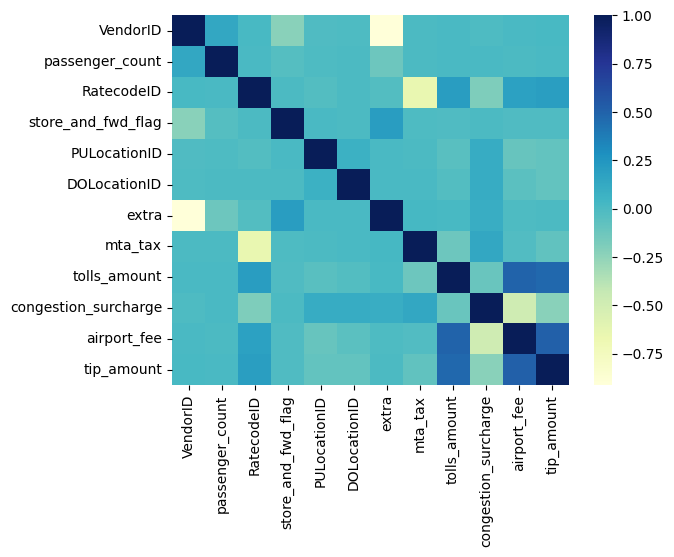

In [36]:
original = pd.read_csv(os.path.join("yellow_cab_data", "processed_train.csv"))

synthetic = pd.read_csv(os.path.join("df_transform_result", "raw_synthetic.csv"))

sns.heatmap(original.drop('improvement_surcharge', axis = 1).corr(), cmap="YlGnBu")

<AxesSubplot: >

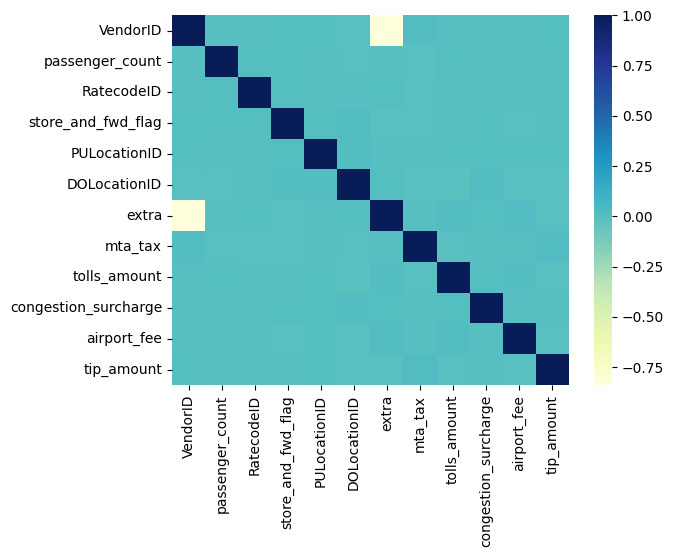

In [37]:
sns.heatmap(synthetic.drop('improvement_surcharge', axis = 1).corr(), cmap="YlGnBu")

In [38]:
original.head()

,VendorID,passenger_count,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee,tip_amount
0,1,0.0,1.0,0,107,148,3.0,0.5,0.00,0.3,2.5,0.00,1.00
1,2,1.0,1.0,0,138,229,1.0,0.5,6.55,0.3,2.5,1.25,10.46
2,2,3.0,1.0,0,138,48,0.0,0.5,6.55,0.3,2.5,1.25,9.32
3,2,2.0,1.0,0,230,48,0.5,0.5,0.00,0.3,2.5,0.00,2.00
4,2,1.0,1.0,0,261,143,0.5,0.5,0.00,0.3,2.5,0.00,4.16


In [39]:
pd.read_csv(os.path.join("df_transform_result", "discretized.csv")).head()

,VendorID,passenger_count,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee,tip_amount
0,0,0,0,0,55,126,7,1,0,1,1,0,1
1,1,1,0,0,67,197,2,1,5,1,1,1,18
2,1,3,0,0,67,38,0,1,5,1,1,1,16
3,1,2,0,0,114,38,1,1,0,1,1,0,3
4,1,1,0,0,132,121,1,1,0,1,1,0,7


In [40]:
pd.read_csv(os.path.join("yellow_cab_data", "yellow_cab_data_synthetic.csv")).head()

,VendorID,passenger_count,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee,tip_amount
0,0,1,0,0,24,197,7,1,0,1,1,0,6
1,1,1,0,0,21,11,2,1,5,1,1,0,3
2,1,1,0,0,11,121,2,1,0,1,1,0,3
3,0,1,0,0,81,199,6,1,0,1,1,0,17
4,1,1,0,1,70,120,0,1,0,1,1,0,2


In [41]:
pd.read_csv(os.path.join("df_transform_result", "raw_synthetic.csv")).head()

,VendorID,passenger_count,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee,tip_amount
0,1,1.0,1.0,0,48,229,3.0,0.5,0.2050,0.3,2.5,0.0,3.6175
1,2,1.0,1.0,0,43,16,1.0,0.5,6.6275,0.3,2.5,0.0,1.9525
2,2,1.0,1.0,0,22,143,1.0,0.5,0.2050,0.3,2.5,0.0,1.9525
3,1,1.0,1.0,0,162,231,2.5,0.5,0.2050,0.3,2.5,0.0,9.7225
4,2,1.0,1.0,1,142,142,0.0,0.5,0.2050,0.3,2.5,0.0,1.3975
